# Contrastive Learning

이 실습에서는 pre-trained network를 활용한 task adoptive contrastive laerning을 수행할 예정입니다. 또, imageNet pre-trained CNN network를 가지고 new dataset에서 네트워크를 학습한 이후 test 성능을 확인하는 process를 진행합니다.

# Classification of Food-101 datasets

As the name says Food-101 has **101** numbers of classes.
Let's have a quick overview of the dataset:



*   No. of food categories (classes): **101**
*   Total no. of images: **101,000** (1000 images/class)
*   Training images/class : **750**
*   Test images/class : **250**



As the name says mini-Food-101 has **10** numbers of classes.
Let's have a quick overview of the dataset:



*   No. of food categories (classes): **10**
*   Total no. of images: **1,000** (100 images/class)
*   Training images/class : **75**
*   Test images/class : **25**

## Load Dataset 

다른 Task에 적용할 수 있는지를 확인하기 위해서 food101-mini dataset을 Load

In [2]:
from google.colab import drive
drive.mount('/content/my_google_drive')

Mounted at /content/my_google_drive


In [3]:
data_path = '/content/my_google_drive/MyDrive/food101-mini' # type in your path here!

In [4]:
# pytorch imports
import torch
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree
import random
from tqdm import tqdm_notebook as tqdm
from IPython.core.debugger import set_trace
import torch.backends.cudnn as cudnn
from torch.cuda.amp import GradScaler, autocast

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "saved_models/ContrastiveLearning/")
NUM_WORKERS = os.cpu_count()

## Data Pre processing

Contrastive Learning에 적용할 수 있는 transform을 만들기

In [5]:
contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
    ]
)

class ContrastiveTransformations:
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

## Data Loader Setting

Image List를 학습하기 위해서 batch 단위로 진행하기 위한 Data Loader를 세팅한다.

In [6]:
train_dataset = ImageFolder(root=data_path, transform =(ContrastiveTransformations(contrast_transforms)))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=125, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


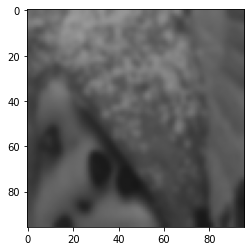

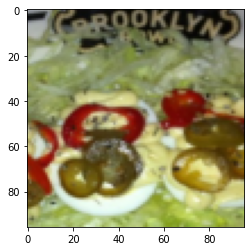

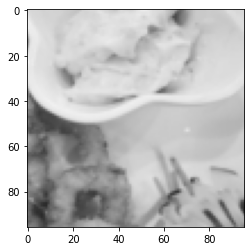

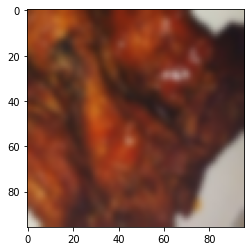

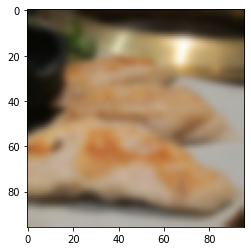

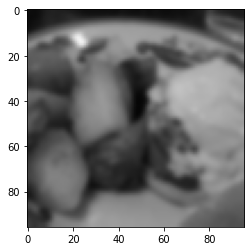

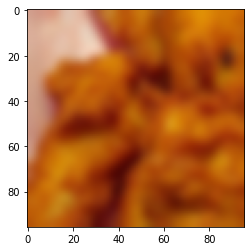

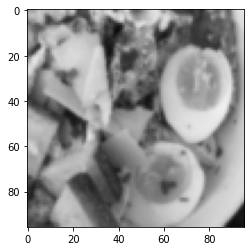

In [7]:
def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img[0], (1, 2, 0)))
    plt.show()

def process():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        custom_imshow(inputs[0])

process()

## Model Load


> imageNet 1k 에서 pre-trained 된 네트워크를 load



In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class ResNetSimCLR(nn.Module):

    def __init__(self, base_model, out_dim):
        super(ResNetSimCLR, self).__init__()
        self.resnet_dict = {"resnet18": models.resnet18(pretrained=False, num_classes=out_dim),
                            "resnet50": models.resnet50(pretrained=False, num_classes=out_dim)}

        self.backbone = self._get_basemodel(base_model)
        dim_mlp = self.backbone.fc.in_features

        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)

    def _get_basemodel(self, model_name):
        try:
            model = self.resnet_dict[model_name]
        except KeyError:
            raise 0
        else:
            return model

    def forward(self, x):
        return self.backbone(x)

## Hyper Parameter Setting

In [10]:
arch = 'resnet18'
NUM_WORKERS = 4
epochs = 5
batch_size = 125
lr = 0.003
weight_decay = 1e-4
seed = 42
out_dim = 128
temperature = 0.07
n_views = 2
gpu_index=0

Main code

In [11]:
import os
import shutil
import torch

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [12]:
assert n_views == 2, "Only two view training is supported. Please use --n-views 2."
# check if gpu training is available
if  torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

model = ResNetSimCLR(base_model=arch, out_dim=out_dim)

optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_loader), eta_min=0,
                                                        last_epoch=-1)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
class SimCLR(object):

    def __init__(self, model=model, optimizer=optimizer, scheduler=scheduler, arch='resnet18', NUM_WORKERS =4, epochs=100, batch_size=128, lr=0.003, weight_decay=1e-4, out_dim=128, temperature=0.07, n_views=2):
        
        self.model = model.to(device)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = torch.nn.CrossEntropyLoss().to(device)

    def info_nce_loss(self, features):

        labels = torch.cat([torch.arange(batch_size) for i in range(n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
        

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

        logits = logits / temperature
        return logits, labels

    def train(self, train_loader):

        scaler = GradScaler(enabled= True)

        n_iter = 0

        for epoch_counter in range(epochs):
           
            for images, _ in tqdm(train_loader):

                images = torch.cat(images, dim=0)
                images = images.to(device)

                with autocast(enabled=True):

                    features = self.model(images)
                    
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)

                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                n_iter += 1

                # if epoch_counter == epochs - 1:
                #     print(features)
                #     print(features.size)

            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()
            print(f"Epoch: {epoch_counter}\tLoss: {loss}")

        print("Training has finished.")
        
        # save model checkpoints
        checkpoint_name = 'checkpoint_{:04d}.pth.tar'.format(epochs)
        save_checkpoint({
            'epoch': epochs,
            'arch': arch,
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, is_best=False, filename=os.path.join(checkpoint_name))

## Train with Contrastive Learning

In [14]:
with torch.cuda.device(gpu_index):
    simclr = SimCLR(model=model, optimizer=optimizer, scheduler=scheduler, arch='resnet18', NUM_WORKERS =4 , epochs=30, batch_size=125, lr=0.003, weight_decay=1e-4, out_dim=128, temperature=0.07, n_views=2)
    simclr.train(train_loader)

<ipython-input-13-23a6a5a0e2ae>:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, _ in tqdm(train_loader):


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0	Loss: 5.448953151702881


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1	Loss: 5.195687294006348


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 2	Loss: 5.080953121185303


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 3	Loss: 4.978320121765137


  0%|          | 0/8 [00:00<?, ?it/s]

tensor([[ 10.4766,   6.6992,   8.0938,  ...,  -5.9141,  -9.5547, -10.6953],
        [  8.7812,  -1.5752,  10.6719,  ...,  -7.4648,  -3.6035,  -4.6328],
        [  5.8516,  -1.9805,  46.5625,  ..., -50.7188, -17.2344, -24.1719],
        ...,
        [ 13.8203,   1.7256,   8.3281,  ...,  -3.8887,  -6.2812,  -6.9609],
        [ 13.7109,   0.4084,   9.0859,  ...,  -4.4961,  -5.4531,  -6.2148],
        [  8.0938,  -0.8706,   9.4844,  ...,  -6.6367,  -3.7188,  -4.6484]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddmmBackward0>)
<built-in method size of Tensor object at 0x7f59c003dea0>
tensor([[  6.0156,   8.6797,  25.5312,  ..., -28.9531, -16.7344, -21.5469],
        [  6.0820,   1.5986,  10.8281,  ...,  -9.7031,  -5.8164,  -7.2383],
        [  5.5781,   3.4609,  12.4531,  ..., -12.2578,  -7.7539,  -9.6094],
        ...,
        [ 13.6641,   2.8086,   7.6797,  ...,  -3.4844,  -6.8867,  -7.5391],
        [  6.8555,  -4.9375,  14.2578,  ..., -11.3594,  -2.1211,  -3.2734],
        

## Feature Extraction

In [15]:
model.eval()
labels = []
n_iter = 0

for images, label in tqdm(train_loader, desc='Running the model inference'):
    # images = torch.cat(images, dim=0)
    images = images[0].to(device)
    labels.append(label.cpu().detach().numpy())

    output = model(images)

    current_outputs = output.cpu().detach().numpy()
    if n_iter == 0: features = current_outputs
    else : features = np.concatenate((features, current_outputs))

    n_iter += 1

<ipython-input-15-2df0b35f2cc0>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for images, label in tqdm(train_loader, desc='Running the model inference'):


Running the model inference:   0%|          | 0/8 [00:00<?, ?it/s]

## t-SNE Visualization

In [16]:
lables = np.array(labels)
labels = np.ravel(labels, order='C')

In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(n_components=2).fit_transform(features)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [19]:
x, y = zip(*tsne)
actual = labels

In [20]:
# data_path_cluster = '/content/my_google_drive/MyDrive/predefined_features/'

# tx = np.load(data_path_cluster+'x_save.npy')
# ty = np.load(data_path_cluster+'y_save.npy')
# tz = np.load(data_path_cluster+'z_save.npy')
# actual = labels

In [21]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    value_range = (np.max(x) - np.min(x))

    starts_from_zero = x - np.min(x)

    return starts_from_zero / value_range
 
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [22]:
classes = ('Baklava', 'Caeser salad', 'Connoli', 'Chicken wings', 'Deviled eggs', 'Eggs benedict', 'Fried calamari', 'Gyoza', 'Macaroni and cheese', 'Ramen')

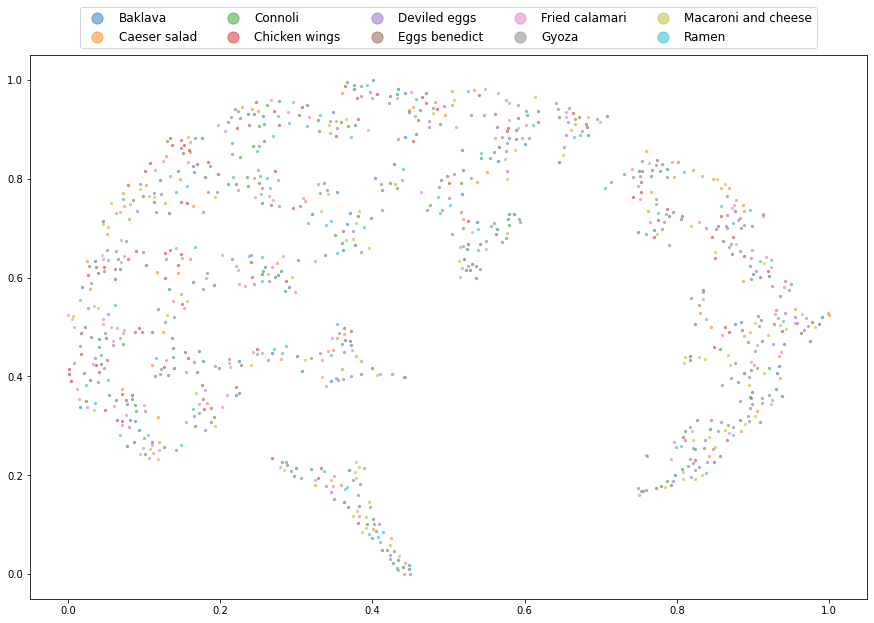

In [23]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

for i, labels in zip(range(10), classes):
    j = np.where(actual == i)[0]
    x_subset = tx[j]
    y_subset = ty[j]
    label_subset = actual[j]
    ax.scatter(x_subset, y_subset, s=5, marker='o', cmap="Set2_r", alpha=0.5, label=labels)
    ax.legend(ncol=5, loc='upper center', bbox_to_anchor=(0.5, 1.1), fontsize=12, markerscale=5)

plt.show()